In [144]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import math
import scipy.stats as stats
import itertools

In [145]:
# Load AKSI stock dataset
df_aksi = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='AKSI.JK')
df_aksi.set_index('Date', drop=True, inplace=True)
df_aksi.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-04,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-05,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-06,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0
2011-04-07,100000000.0,100000000.0,100000000.0,100000000.0,99000000.0,2500.0


In [146]:
# Check datatypes
print(df_aksi.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [147]:
# Check missing value
print(df_aksi.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [148]:
# Fill missing value using mean imputation
for i in df_aksi[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_aksi[i].fillna(df_aksi[i].mean(), inplace=True)

print(df_aksi.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


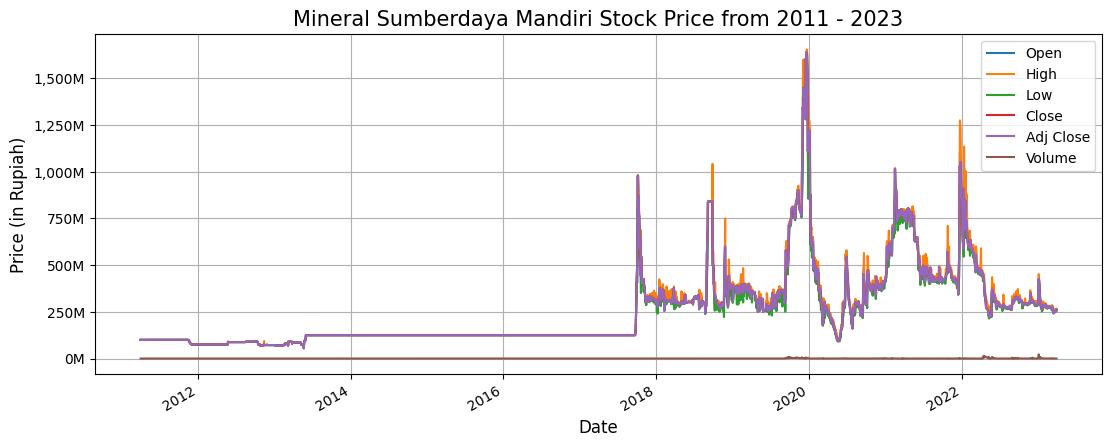

In [149]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_aksi.plot(figsize=(13,5))
plt.title('Mineral Sumberdaya Mandiri Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [150]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_aksi[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [151]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]
 [0.02839117]] 

Testing Scaled:  [[0.43217666]
 [0.40063091]
 [0.49842271]
 [0.4637224 ]
 [0.44164038]]


In [152]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [153]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 9s 105ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 2/10
24/24 [==============================] - 1s 45ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 3/10
24/24 [==============================] - 1s 40ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 4/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 5/10
24/24 [==============================] - 1s 56ms/step - loss: 0.0012 - val_loss: 0.0024
Epoch 6/10
24/24 [==============================] - 1s 46ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 7/10
24/24 [==============================] - 1s 46ms/step - loss: 9.7861e-04 - val_loss: 0.0021
Epoch 8/10
24/24 [==============================] - 1s 51ms/step - loss: 8.6680e-04 - val_loss: 0.0021
Epoch 9/10
24/24 [==============================] - 1s 46ms/step - loss: 7.8678e-04 - val_loss: 0.0022
Epoch 10/10
24/24 [==============================] - 1s 45ms/step - loss: 7.2634e-04 - val_loss:

In [154]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 1s 14ms/step
Mean Absolute Error (MAE): 0.0116605
Mean Absolute Percentage Error (MAPE): 0.07697
Root Mean Squared Error (RMSE): 0.01656
Mean Squared Error (MSE): 0.0002741
R-Squared (R2): 0.329813
T-Statistic 0.8632
P-Value 9.746867077548363e-14
Elapsed Time (min): 21.12


7/7 [==============================] - 0s 11ms/step


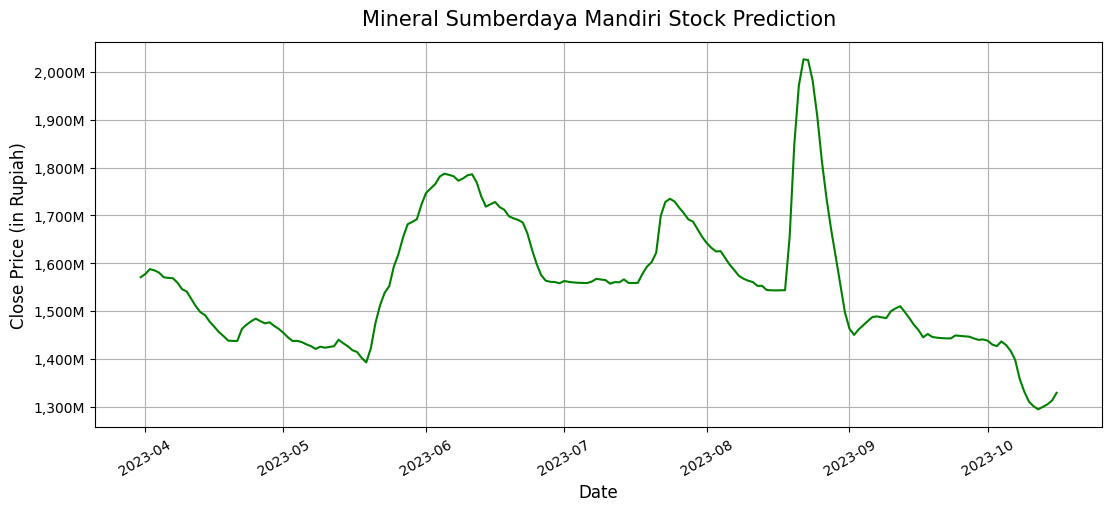

In [155]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [156]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 22s 560ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 2/10
24/24 [==============================] - 12s 488ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 3/10
24/24 [==============================] - 12s 483ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 4/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 6/10
24/24 [==============================] - 12s 503ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 7/10
24/24 [==============================] - 11s 449ms/step - loss: 9.2783e-04 - val_loss: 0.0036
Epoch 8/10
24/24 [==============================] - 11s 442ms/step - loss: 8.4768e-04 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 11s 472ms/step - loss: 8.9087e-04 - val_loss: 0.0022
Epoch 10/10
24/24 [==============================] - 11s 480ms/step - loss: 7.6

In [157]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 62ms/step
Mean Absolute Error (MAE): 0.013728
Mean Absolute Percentage Error (MAPE): 0.08885
Root Mean Squared Error (RMSE): 0.01873
Mean Squared Error (MSE): 0.0003509
R-Squared (R2): 0.141948
T-Statistic 0.8768
P-Value 5.840554277193599e-13
Elapsed Time (min): 125.25


7/7 [==============================] - 0s 61ms/step


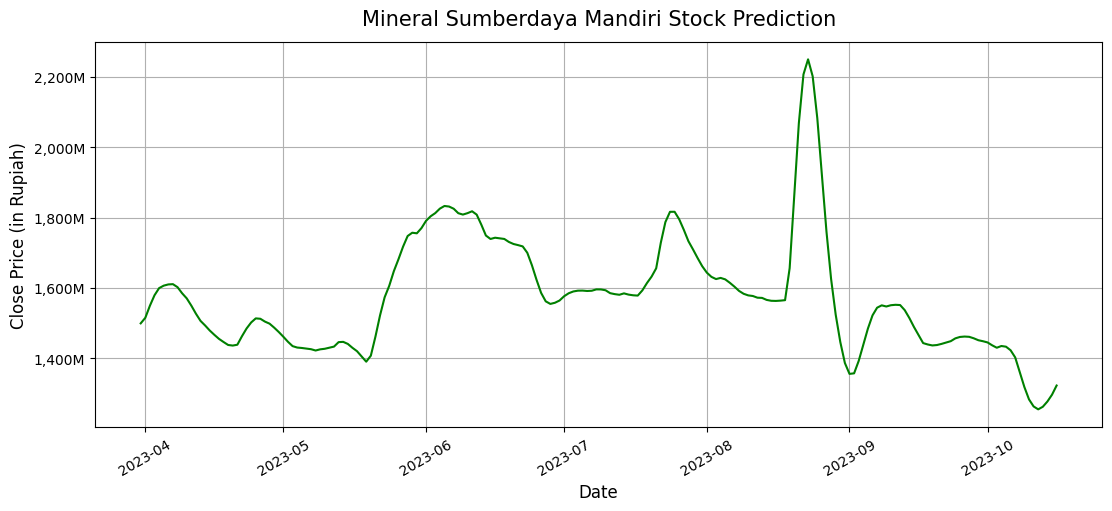

In [158]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [159]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 19s 501ms/step - loss: 0.0171 - val_loss: 0.0694
Epoch 2/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0139 - val_loss: 0.0595
Epoch 3/10
24/24 [==============================] - 12s 522ms/step - loss: 0.0132 - val_loss: 0.0549
Epoch 4/10
24/24 [==============================] - 12s 509ms/step - loss: 0.0126 - val_loss: 0.0525
Epoch 5/10
24/24 [==============================] - 13s 522ms/step - loss: 0.0128 - val_loss: 0.0515
Epoch 6/10
24/24 [==============================] - 11s 438ms/step - loss: 0.0123 - val_loss: 0.0500
Epoch 7/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0119 - val_loss: 0.0490
Epoch 8/10
24/24 [==============================] - 10s 426ms/step - loss: 0.0117 - val_loss: 0.0478
Epoch 9/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0113 - val_loss: 0.0469
Epoch 10/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0110 - val_lo

In [160]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 0.0407017
Mean Absolute Percentage Error (MAPE): 0.26025
Root Mean Squared Error (RMSE): 0.04476
Mean Squared Error (MSE): 0.0020034
R-Squared (R2): -3.898347
T-Statistic 0.676
P-Value 4.226222461485406e-21
Elapsed Time (min): 120.22


7/7 [==============================] - 0s 51ms/step


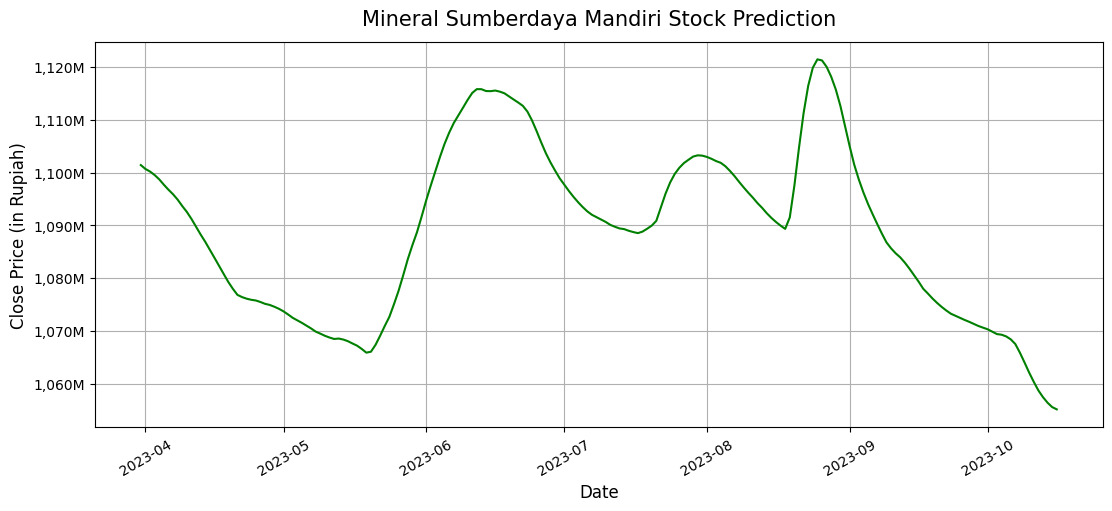

In [161]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [162]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 21s 501ms/step - loss: 0.0056 - val_loss: 0.0082
Epoch 2/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 3/10
24/24 [==============================] - 12s 488ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 12s 521ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 5/10
24/24 [==============================] - 13s 524ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 11s 465ms/step - loss: 9.9933e-04 - val_loss: 0.0030
Epoch 7/10
24/24 [==============================] - 11s 453ms/step - loss: 8.9406e-04 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 10s 437ms/step - loss: 8.5490e-04 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 11s 446ms/step - loss: 8.7848e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 11s 462ms/step - loss:

In [163]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.0093744
Mean Absolute Percentage Error (MAPE): 0.06011
Root Mean Squared Error (RMSE): 0.01526
Mean Squared Error (MSE): 0.0002329
R-Squared (R2): 0.43057
T-Statistic 0.88
P-Value 8.995121271102025e-13
Elapsed Time (min): 124.63


7/7 [==============================] - 0s 50ms/step


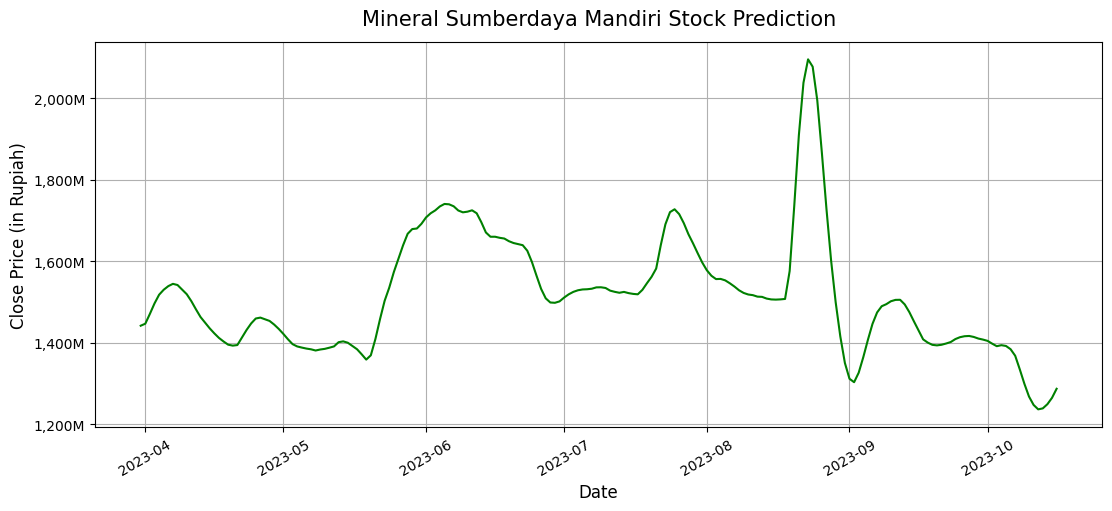

In [164]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [165]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 20s 524ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 2/10
24/24 [==============================] - 12s 506ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 3/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0023 - val_loss: 0.0072
Epoch 4/10
24/24 [==============================] - 11s 468ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 6/10
24/24 [==============================] - 12s 482ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 7/10
24/24 [==============================] - 11s 480ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 11s 479ms/step - loss: 0.0013 - val_lo

In [166]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 51ms/step
Mean Absolute Error (MAE): 0.0108179
Mean Absolute Percentage Error (MAPE): 0.06903
Root Mean Squared Error (RMSE): 0.01669
Mean Squared Error (MSE): 0.0002787
R-Squared (R2): 0.318511
T-Statistic 0.8811
P-Value 1.050909142694123e-12
Elapsed Time (min): 122.99


7/7 [==============================] - 0s 50ms/step


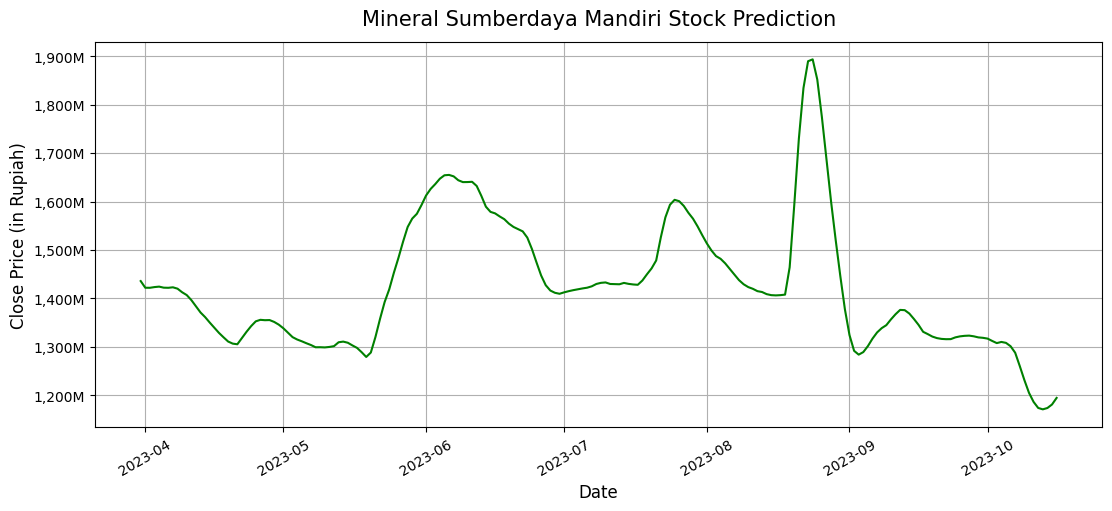

In [167]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [168]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 19s 487ms/step - loss: 0.0267 - val_loss: 0.1280
Epoch 2/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0267 - val_loss: 0.1263
Epoch 3/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0261 - val_loss: 0.1247
Epoch 4/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0255 - val_loss: 0.1230
Epoch 5/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0252 - val_loss: 0.1213
Epoch 6/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0246 - val_loss: 0.1197
Epoch 7/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0244 - val_loss: 0.1180
Epoch 8/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0242 - val_loss: 0.1164
Epoch 9/10
24/24 [==============================] - 10s 421ms/step - loss: 0.0236 - val_loss: 0.1148
Epoch 10/10
24/24 [==============================] - 10s 439ms/step - loss: 0.0233 - val_lo

In [169]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 47ms/step
Mean Absolute Error (MAE): 0.1411001
Mean Absolute Percentage Error (MAPE): 0.93828
Root Mean Squared Error (RMSE): 0.14251
Mean Squared Error (MSE): 0.0203102
R-Squared (R2): -48.658497
T-Statistic 0.7801
P-Value 1.3998354345177736e-17
Elapsed Time (min): 114.08


7/7 [==============================] - 0s 49ms/step


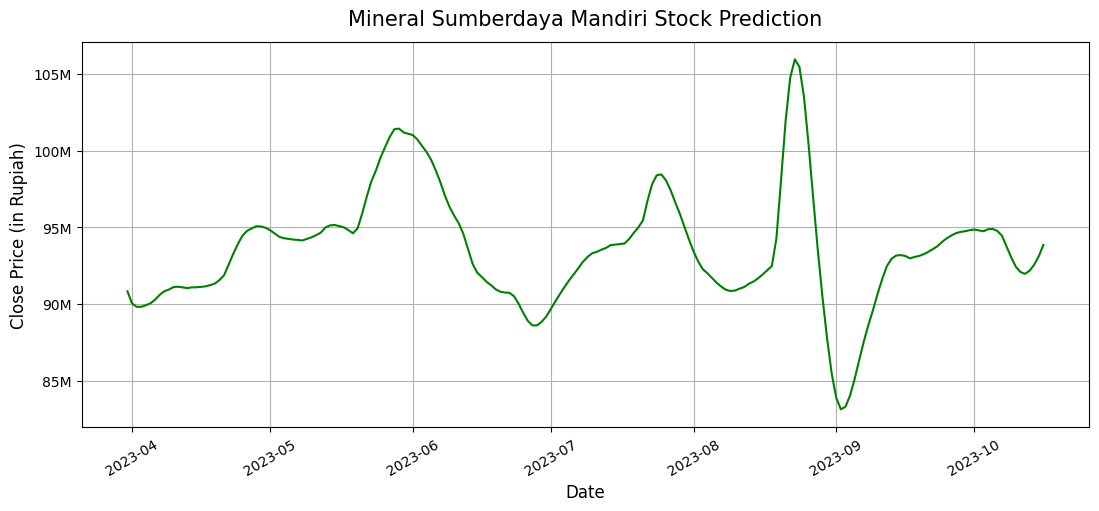

In [170]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [171]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 19s 511ms/step - loss: 0.0175 - val_loss: 0.0651
Epoch 2/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0149 - val_loss: 0.0589
Epoch 3/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0143 - val_loss: 0.0572
Epoch 4/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0136 - val_loss: 0.0529
Epoch 5/10
24/24 [==============================] - 10s 428ms/step - loss: 0.0126 - val_loss: 0.0479
Epoch 6/10
24/24 [==============================] - 11s 463ms/step - loss: 0.0119 - val_loss: 0.0475
Epoch 7/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0111 - val_loss: 0.0439
Epoch 8/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0107 - val_loss: 0.0417
Epoch 9/10
24/24 [==============================] - 10s 425ms/step - loss: 0.0101 - val_loss: 0.0399
Epoch 10/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0095 - val_lo

In [172]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 53ms/step
Mean Absolute Error (MAE): 0.032883
Mean Absolute Percentage Error (MAPE): 0.20994
Root Mean Squared Error (RMSE): 0.03695
Mean Squared Error (MSE): 0.001365
R-Squared (R2): -2.337351
T-Statistic 0.6687
P-Value 2.57686168050714e-21
Elapsed Time (min): 115.98


7/7 [==============================] - 0s 57ms/step


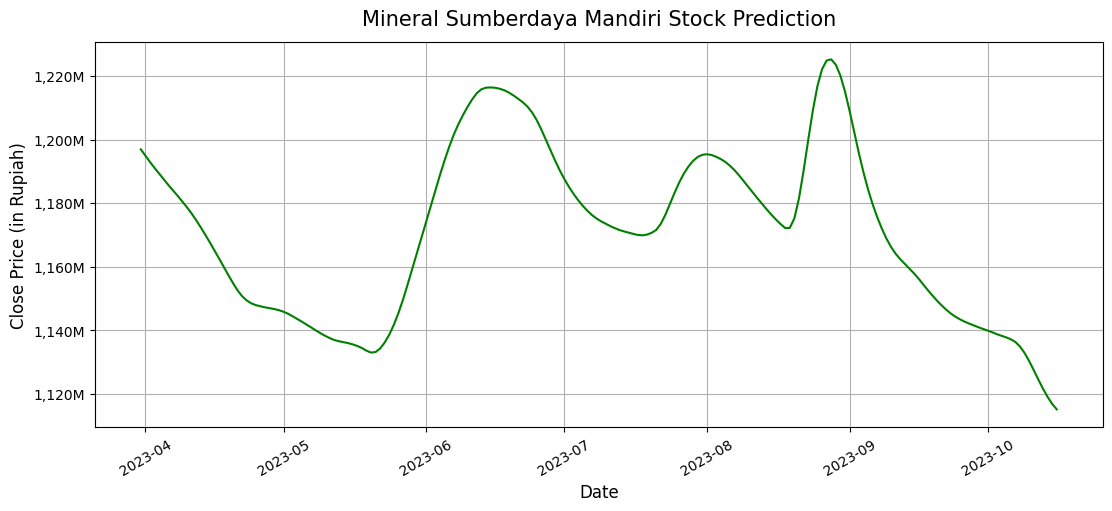

In [173]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [174]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 21s 555ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 2/10
24/24 [==============================] - 11s 476ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 3/10
24/24 [==============================] - 13s 530ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 4/10
24/24 [==============================] - 12s 512ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 5/10
24/24 [==============================] - 12s 492ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 6/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 7/10
24/24 [==============================] - 12s 495ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 8/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 9/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0011 - val_lo

In [175]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 68ms/step
Mean Absolute Error (MAE): 0.0147873
Mean Absolute Percentage Error (MAPE): 0.09769
Root Mean Squared Error (RMSE): 0.02087
Mean Squared Error (MSE): 0.0004355
R-Squared (R2): -0.064861
T-Statistic 0.8646
P-Value 1.1533138268189636e-13
Elapsed Time (min): 128.11


7/7 [==============================] - 0s 52ms/step


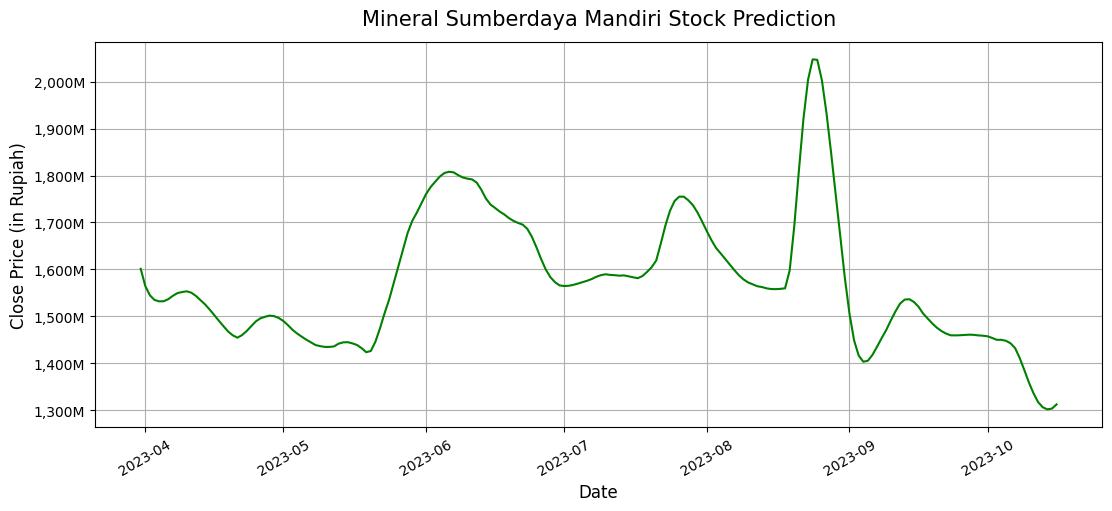

In [176]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [177]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 19s 479ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 2/10
24/24 [==============================] - 10s 429ms/step - loss: 0.0018 - val_loss: 0.0042
Epoch 3/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 5/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 11s 474ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 11s 480ms/step - loss: 9.4067e-04 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 11s 480ms/step - loss: 8.4168e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 11s 458ms/step - loss: 8.3119e

In [178]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.0083481
Mean Absolute Percentage Error (MAPE): 0.05275
Root Mean Squared Error (RMSE): 0.01463
Mean Squared Error (MSE): 0.0002139
R-Squared (R2): 0.476992
T-Statistic 0.8827
P-Value 1.32504228943231e-12
Elapsed Time (min): 119.66


7/7 [==============================] - 0s 45ms/step


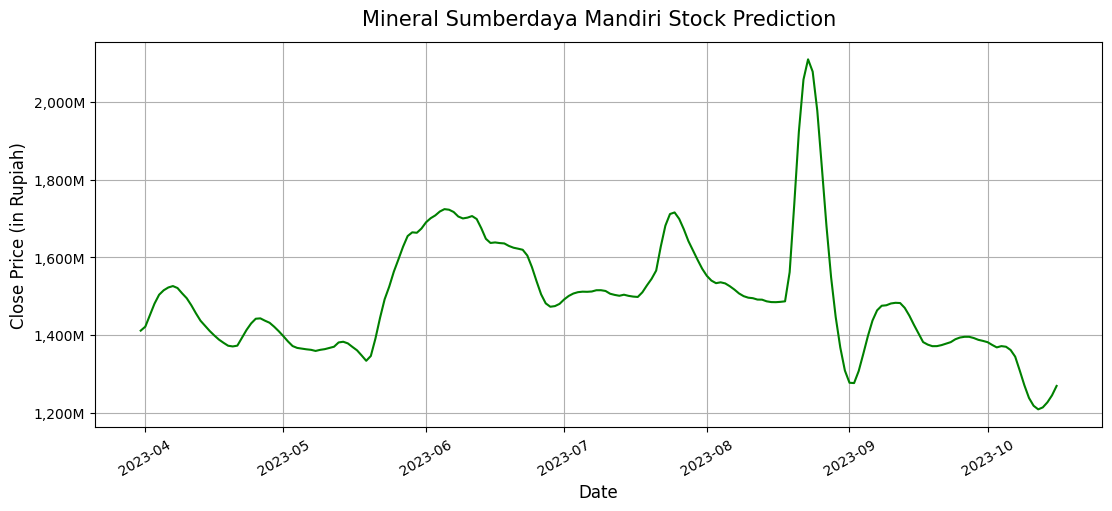

In [179]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [180]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 19s 510ms/step - loss: 0.0224 - val_loss: 0.0993
Epoch 2/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0192 - val_loss: 0.0885
Epoch 3/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0171 - val_loss: 0.0812
Epoch 4/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0160 - val_loss: 0.0757
Epoch 5/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0153 - val_loss: 0.0715
Epoch 6/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0148 - val_loss: 0.0682
Epoch 7/10
24/24 [==============================] - 11s 463ms/step - loss: 0.0143 - val_loss: 0.0657
Epoch 8/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0140 - val_loss: 0.0638
Epoch 9/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0139 - val_loss: 0.0621
Epoch 10/10
24/24 [==============================] - 11s 481ms/step - loss: 0.0138 - val_lo

In [181]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 0.0564243
Mean Absolute Percentage Error (MAPE): 0.36556
Root Mean Squared Error (RMSE): 0.05977
Mean Squared Error (MSE): 0.003572
R-Squared (R2): -7.733444
T-Statistic 0.7484
P-Value 9.167251886085774e-19
Elapsed Time (min): 118.91


7/7 [==============================] - 0s 51ms/step


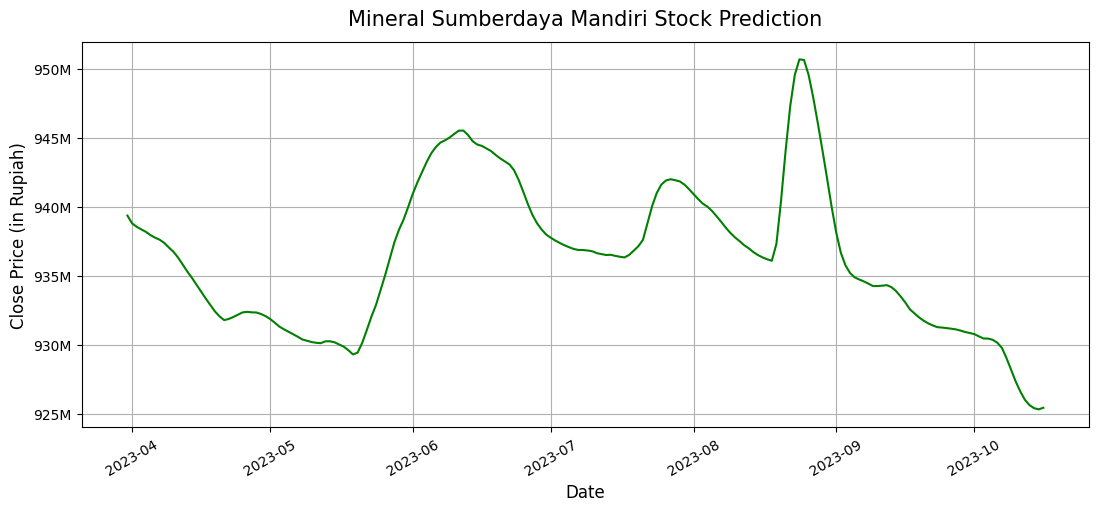

In [182]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [183]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 22s 529ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 2/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 3/10
24/24 [==============================] - 12s 496ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 12s 484ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 11s 474ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 12s 486ms/step - loss: 0.0011 - val_loss: 0.0037
Epoch 8/10
24/24 [==============================] - 12s 522ms/step - loss: 9.4391e-04 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 11s 465ms/step - loss: 7.6087e-04 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 12s 480ms/step - loss: 8.3786e

In [184]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 52ms/step
Mean Absolute Error (MAE): 0.0088794
Mean Absolute Percentage Error (MAPE): 0.05601
Root Mean Squared Error (RMSE): 0.01428
Mean Squared Error (MSE): 0.0002039
R-Squared (R2): 0.501388
T-Statistic 0.8974
P-Value 1.1523400289537022e-11
Elapsed Time (min): 127.26


7/7 [==============================] - 0s 53ms/step


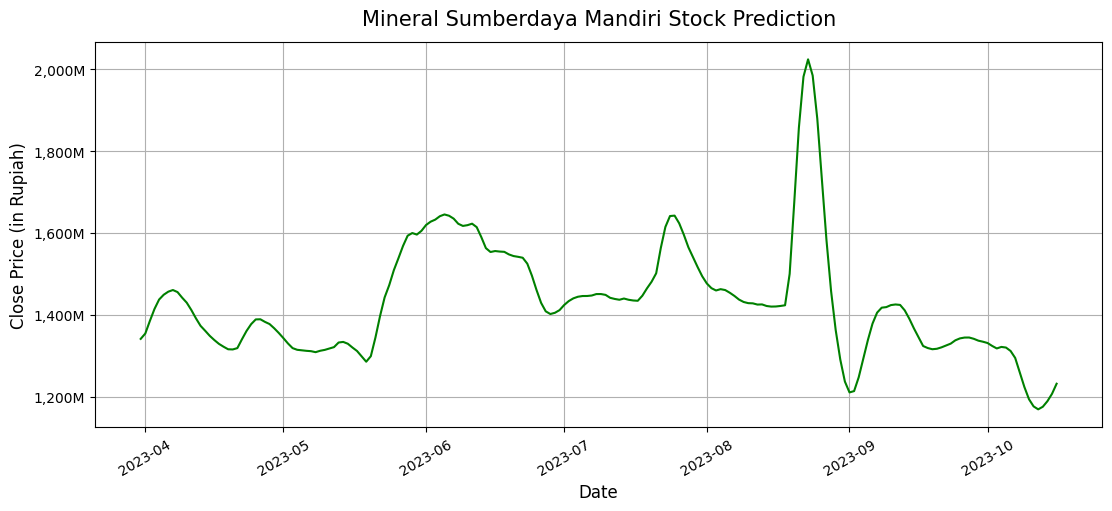

In [185]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [186]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 19s 529ms/step - loss: 0.0051 - val_loss: 0.0096
Epoch 2/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0029 - val_loss: 0.0057
Epoch 3/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0025 - val_loss: 0.0056
Epoch 4/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 5/10
24/24 [==============================] - 12s 495ms/step - loss: 0.0021 - val_loss: 0.0092
Epoch 6/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 8/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 12s 489ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 10/10
24/24 [==============================] - 11s 472ms/step - loss: 0.0013 - val_lo

In [187]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 61ms/step
Mean Absolute Error (MAE): 0.0102312
Mean Absolute Percentage Error (MAPE): 0.06505
Root Mean Squared Error (RMSE): 0.01791
Mean Squared Error (MSE): 0.0003208
R-Squared (R2): 0.21568
T-Statistic 0.8615
P-Value 7.821106501153252e-14
Elapsed Time (min): 120.75


7/7 [==============================] - 0s 61ms/step


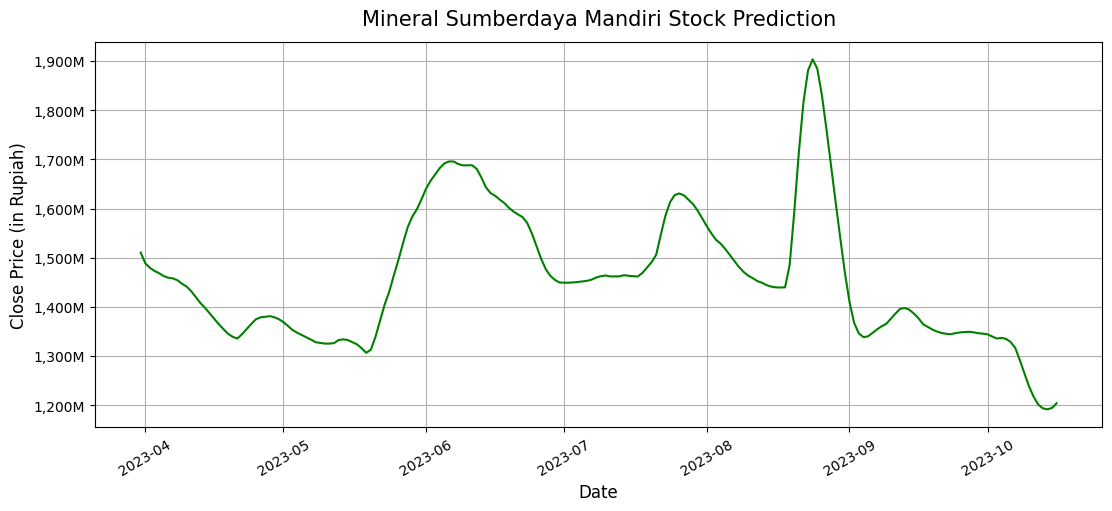

In [188]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [189]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 18s 466ms/step - loss: 0.0261 - val_loss: 0.1230
Epoch 2/10
24/24 [==============================] - 10s 405ms/step - loss: 0.0258 - val_loss: 0.1224
Epoch 3/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0257 - val_loss: 0.1218
Epoch 4/10
24/24 [==============================] - 10s 411ms/step - loss: 0.0255 - val_loss: 0.1212
Epoch 5/10
24/24 [==============================] - 10s 419ms/step - loss: 0.0253 - val_loss: 0.1205
Epoch 6/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0251 - val_loss: 0.1199
Epoch 7/10
24/24 [==============================] - 13s 525ms/step - loss: 0.0250 - val_loss: 0.1192
Epoch 8/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0248 - val_loss: 0.1186
Epoch 9/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0247 - val_loss: 0.1179
Epoch 10/10
24/24 [==============================] - 10s 432ms/step - loss: 0.0245 - val_lo

In [190]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)  

8/8 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 0.1463257
Mean Absolute Percentage Error (MAPE): 0.97308
Root Mean Squared Error (RMSE): 0.14776
Mean Squared Error (MSE): 0.0218322
R-Squared (R2): -52.379844
T-Statistic 0.8879
P-Value 2.76632232745766e-12
Elapsed Time (min): 113.75


7/7 [==============================] - 0s 56ms/step


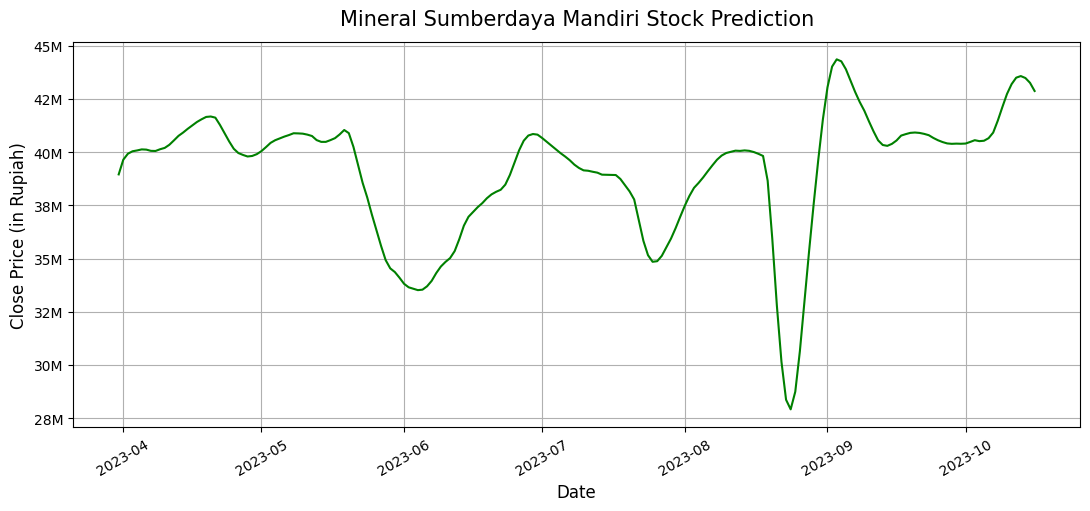

In [191]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [192]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 19s 539ms/step - loss: 0.0174 - val_loss: 0.0665
Epoch 2/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0136 - val_loss: 0.0568
Epoch 3/10
24/24 [==============================] - 11s 443ms/step - loss: 0.0127 - val_loss: 0.0527
Epoch 4/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0119 - val_loss: 0.0477
Epoch 5/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0114 - val_loss: 0.0454
Epoch 6/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0106 - val_loss: 0.0426
Epoch 7/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0102 - val_loss: 0.0406
Epoch 8/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0098 - val_loss: 0.0387
Epoch 9/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0094 - val_loss: 0.0358
Epoch 10/10
24/24 [==============================] - 11s 464ms/step - loss: 0.0091 - val_lo

In [193]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 59ms/step
Mean Absolute Error (MAE): 0.0358757
Mean Absolute Percentage Error (MAPE): 0.22994
Root Mean Squared Error (RMSE): 0.03962
Mean Squared Error (MSE): 0.00157
R-Squared (R2): -2.838739
T-Statistic 0.6871
P-Value 9.060317660033584e-21
Elapsed Time (min): 117.2


7/7 [==============================] - 0s 56ms/step


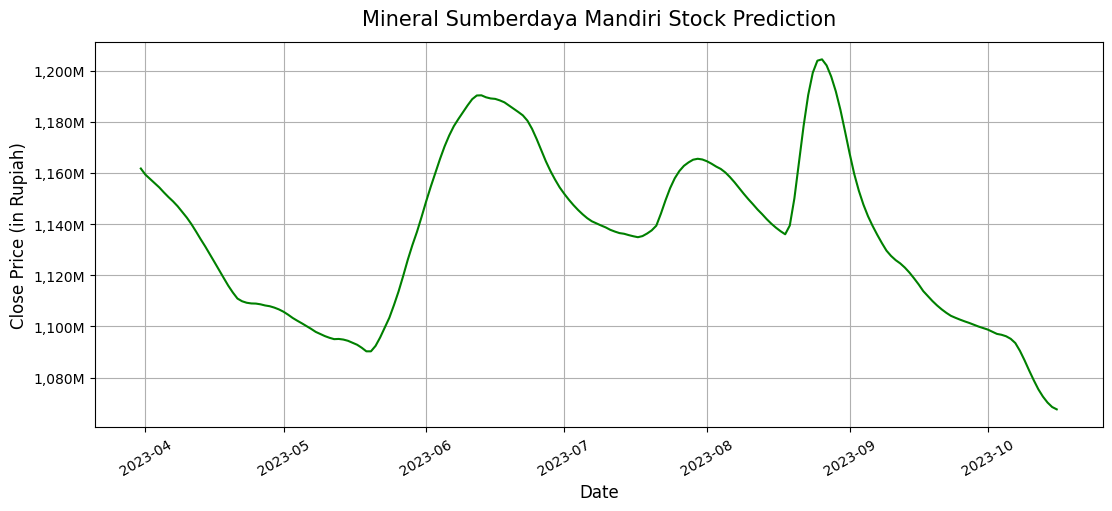

In [194]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [195]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 18s 458ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 2/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 3/10
24/24 [==============================] - 10s 422ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 5/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 7/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 8/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 9/10
24/24 [==============================] - 11s 439ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 10/10
24/24 [==============================] - 10s 427ms/step - loss: 0.0012 - val_lo

In [196]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 53ms/step
Mean Absolute Error (MAE): 0.0166904
Mean Absolute Percentage Error (MAPE): 0.11066
Root Mean Squared Error (RMSE): 0.02259
Mean Squared Error (MSE): 0.0005104
R-Squared (R2): -0.247851
T-Statistic 0.8687
P-Value 1.9710333354610449e-13
Elapsed Time (min): 111.45


7/7 [==============================] - 0s 55ms/step


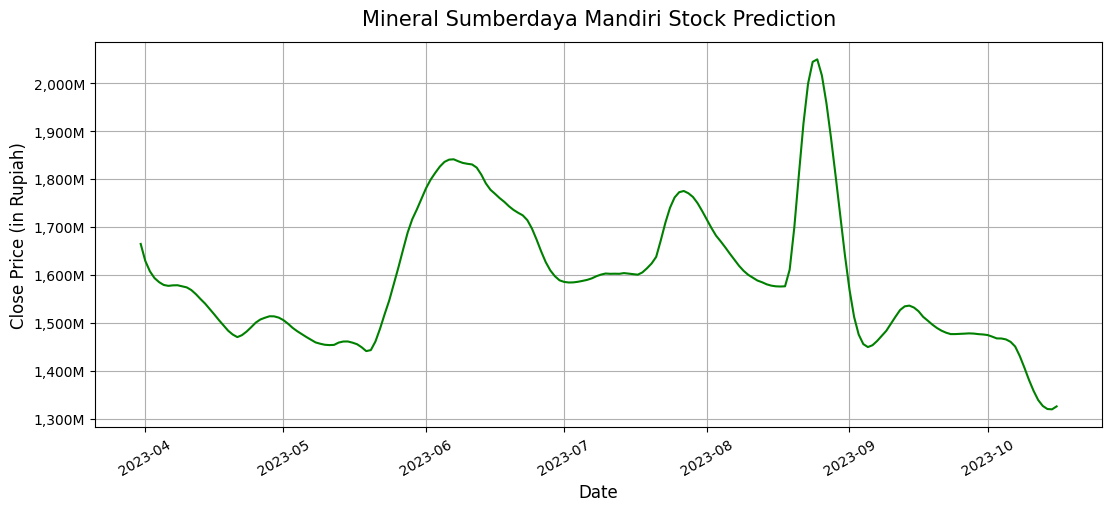

In [197]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [198]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 17s 418ms/step - loss: 0.0099 - val_loss: 0.0042
Epoch 2/10
24/24 [==============================] - 9s 382ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 3/10
24/24 [==============================] - 10s 400ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 4/10
24/24 [==============================] - 10s 411ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 5/10
24/24 [==============================] - 9s 362ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 6/10
24/24 [==============================] - 9s 373ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 7/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 8/10
24/24 [==============================] - 9s 375ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 9/10
24/24 [==============================] - 10s 400ms/step - loss: 9.6773e-04 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 9s 388ms/step - loss: 0.0011 - val_loss

In [199]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Error (MAE): 0.0110326
Mean Absolute Percentage Error (MAPE): 0.0704
Root Mean Squared Error (RMSE): 0.01736
Mean Squared Error (MSE): 0.0003012
R-Squared (R2): 0.263464
T-Statistic 0.8681
P-Value 1.8118589040130167e-13
Elapsed Time (min): 101.21


7/7 [==============================] - 0s 49ms/step


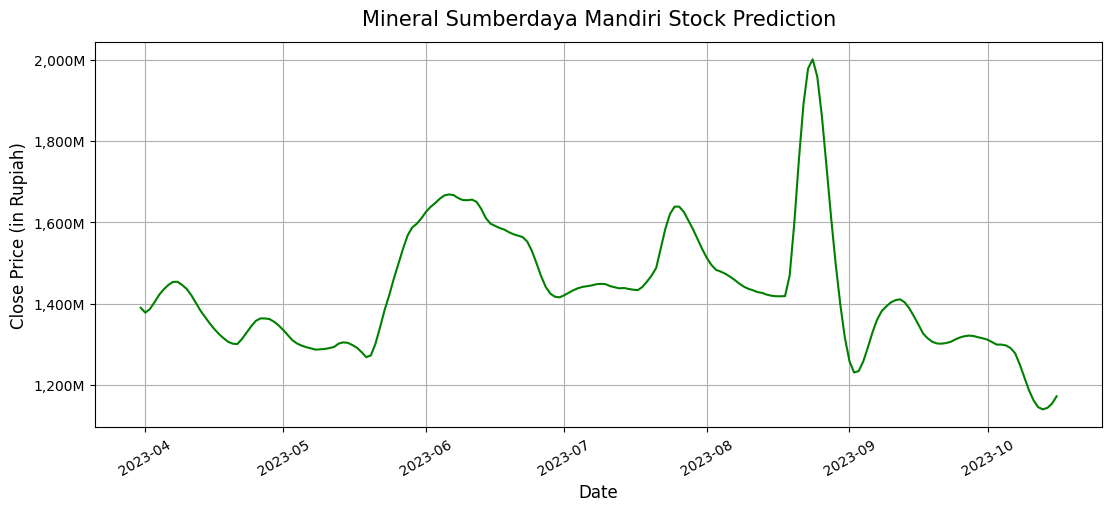

In [200]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [201]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 18s 460ms/step - loss: 0.3419 - val_loss: 0.0885
Epoch 2/10
24/24 [==============================] - 10s 416ms/step - loss: 0.2349 - val_loss: 0.0526
Epoch 3/10
24/24 [==============================] - 10s 421ms/step - loss: 0.1790 - val_loss: 0.0332
Epoch 4/10
24/24 [==============================] - 10s 431ms/step - loss: 0.1417 - val_loss: 0.0221
Epoch 5/10
24/24 [==============================] - 13s 538ms/step - loss: 0.1146 - val_loss: 0.0157
Epoch 6/10
24/24 [==============================] - 12s 501ms/step - loss: 0.0940 - val_loss: 0.0124
Epoch 7/10
24/24 [==============================] - 12s 495ms/step - loss: 0.0782 - val_loss: 0.0112
Epoch 8/10
24/24 [==============================] - 12s 513ms/step - loss: 0.0659 - val_loss: 0.0114
Epoch 9/10
24/24 [==============================] - 12s 485ms/step - loss: 0.0559 - val_loss: 0.0126
Epoch 10/10
24/24 [==============================] - 12s 520ms/step - loss: 0.0483 - val_lo

In [202]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 60ms/step
Mean Absolute Error (MAE): 0.1210827
Mean Absolute Percentage Error (MAPE): 0.83573
Root Mean Squared Error (RMSE): 0.12277
Mean Squared Error (MSE): 0.0150717
R-Squared (R2): -35.850371
T-Statistic 0.6185
P-Value 1.0887330623686993e-22
Elapsed Time (min): 122.5


7/7 [==============================] - 1s 74ms/step


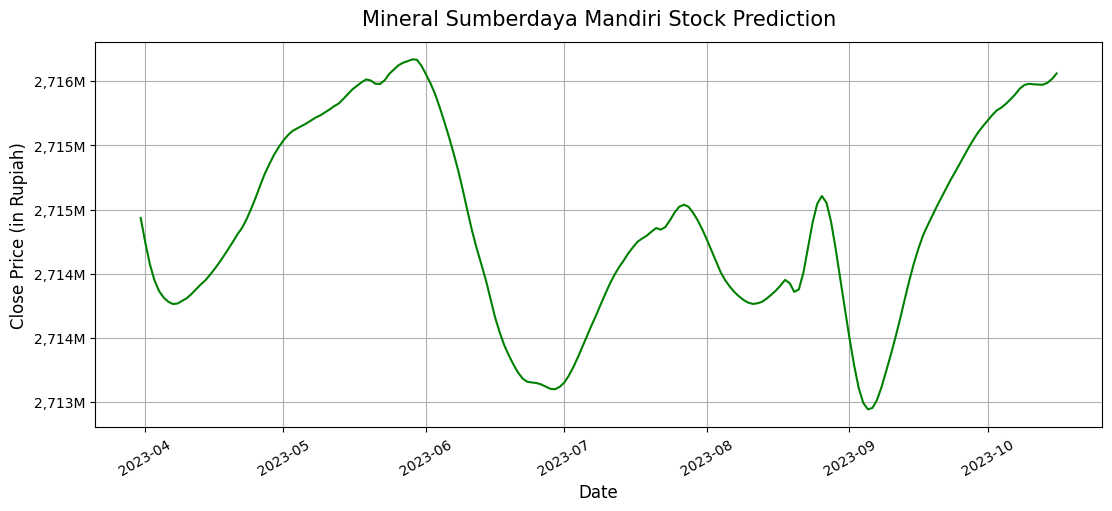

In [203]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [204]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 25s 525ms/step - loss: 0.0446 - val_loss: 0.0070
Epoch 2/10
24/24 [==============================] - 11s 437ms/step - loss: 0.0042 - val_loss: 0.0081
Epoch 3/10
24/24 [==============================] - 9s 394ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 4/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0027 - val_loss: 0.0041
Epoch 5/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 6/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 7/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0016 - val_loss: 0.0039
Epoch 8/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 9/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 10/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0013 - val_los

In [205]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 59ms/step
Mean Absolute Error (MAE): 0.0109521
Mean Absolute Percentage Error (MAPE): 0.07034
Root Mean Squared Error (RMSE): 0.01851
Mean Squared Error (MSE): 0.0003428
R-Squared (R2): 0.161754
T-Statistic 0.827
P-Value 1.413592745123731e-15
Elapsed Time (min): 121.19


7/7 [==============================] - 0s 57ms/step


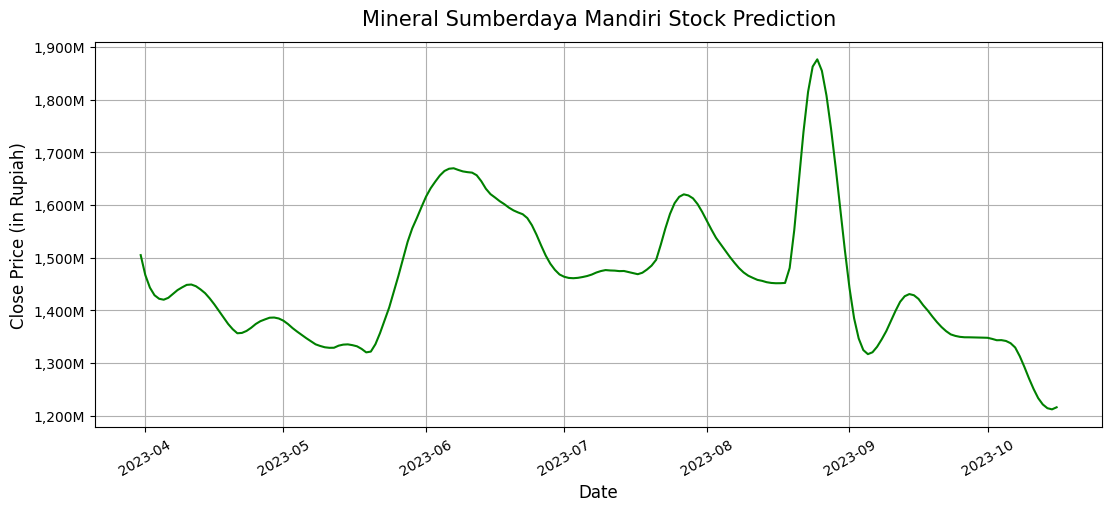

In [206]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [207]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 20s 535ms/step - loss: 0.0175 - val_loss: 0.0105
Epoch 2/10
24/24 [==============================] - 11s 459ms/step - loss: 0.0041 - val_loss: 0.0113
Epoch 3/10
24/24 [==============================] - 12s 514ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 4/10
24/24 [==============================] - 13s 537ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 5/10
24/24 [==============================] - 12s 515ms/step - loss: 0.0030 - val_loss: 0.0071
Epoch 6/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0029 - val_loss: 0.0042
Epoch 7/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 8/10
24/24 [==============================] - 11s 463ms/step - loss: 0.0023 - val_loss: 0.0036
Epoch 9/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 10/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0019 - val_lo

In [208]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 58ms/step
Mean Absolute Error (MAE): 0.0279379
Mean Absolute Percentage Error (MAPE): 0.18246
Root Mean Squared Error (RMSE): 0.03213
Mean Squared Error (MSE): 0.0010325
R-Squared (R2): -1.524418
T-Statistic 0.8238
P-Value 1.010559963380913e-15
Elapsed Time (min): 126.1


7/7 [==============================] - 0s 58ms/step


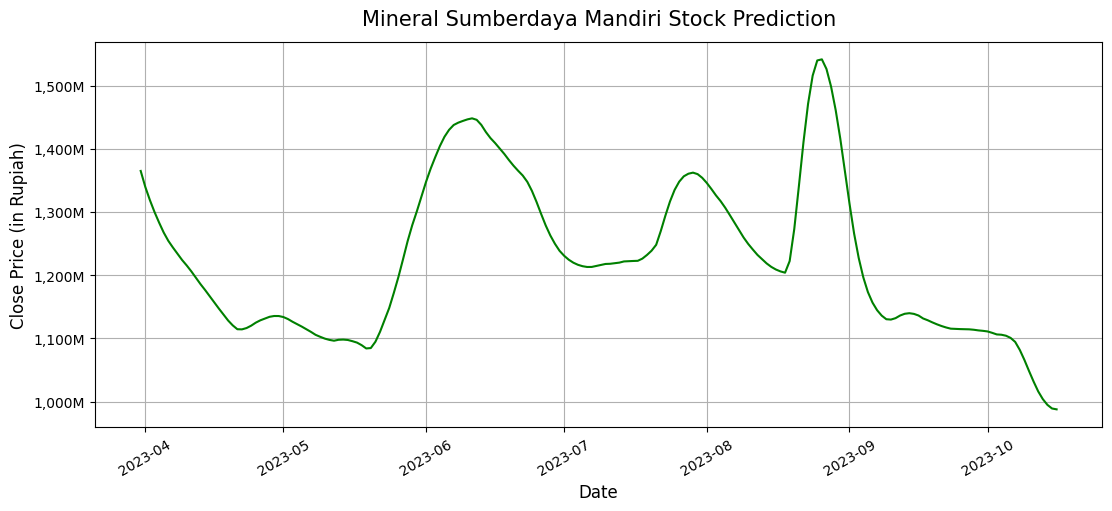

In [209]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [210]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 18s 458ms/step - loss: 0.0460 - val_loss: 0.0145
Epoch 2/10
24/24 [==============================] - 10s 397ms/step - loss: 0.0457 - val_loss: 0.0146
Epoch 3/10
24/24 [==============================] - 10s 420ms/step - loss: 0.0454 - val_loss: 0.0147
Epoch 4/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0451 - val_loss: 0.0148
Epoch 5/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0448 - val_loss: 0.0150
Epoch 6/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0444 - val_loss: 0.0151
Epoch 7/10
24/24 [==============================] - 10s 400ms/step - loss: 0.0442 - val_loss: 0.0152
Epoch 8/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0438 - val_loss: 0.0153
Epoch 9/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0435 - val_loss: 0.0154
Epoch 10/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0431 - val_los

In [211]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 57ms/step
Mean Absolute Error (MAE): 0.115355
Mean Absolute Percentage Error (MAPE): 0.79716
Root Mean Squared Error (RMSE): 0.11715
Mean Squared Error (MSE): 0.0137251
R-Squared (R2): -32.557885
T-Statistic 0.7865
P-Value 2.5075138199681455e-17
Elapsed Time (min): 107.27


7/7 [==============================] - 0s 46ms/step


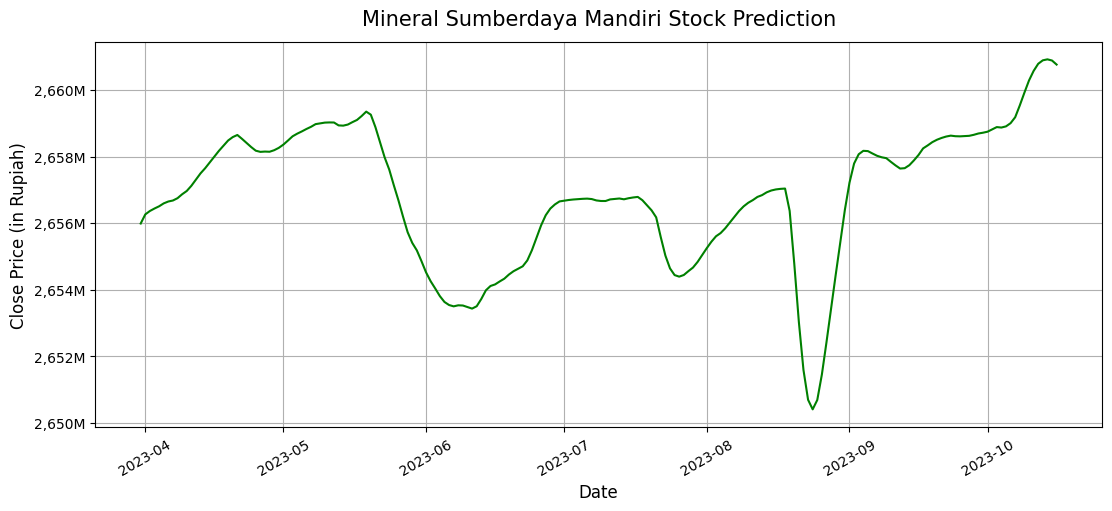

In [212]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [213]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 17s 453ms/step - loss: 0.0285 - val_loss: 0.0640
Epoch 2/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0149 - val_loss: 0.0590
Epoch 3/10
24/24 [==============================] - 10s 420ms/step - loss: 0.0149 - val_loss: 0.0639
Epoch 4/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0148 - val_loss: 0.0621
Epoch 5/10
24/24 [==============================] - 10s 400ms/step - loss: 0.0147 - val_loss: 0.0619
Epoch 6/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0146 - val_loss: 0.0619
Epoch 7/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0146 - val_loss: 0.0592
Epoch 8/10
24/24 [==============================] - 10s 435ms/step - loss: 0.0145 - val_loss: 0.0641
Epoch 9/10
24/24 [==============================] - 11s 435ms/step - loss: 0.0145 - val_loss: 0.0598
Epoch 10/10
24/24 [==============================] - 10s 424ms/step - loss: 0.0143 - val_lo

In [214]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.0444058
Mean Absolute Percentage Error (MAPE): 0.28396
Root Mean Squared Error (RMSE): 0.04873
Mean Squared Error (MSE): 0.0023744
R-Squared (R2): -4.80547
T-Statistic 0.7313
P-Value 2.328149206373308e-19
Elapsed Time (min): 108.9


7/7 [==============================] - 0s 54ms/step


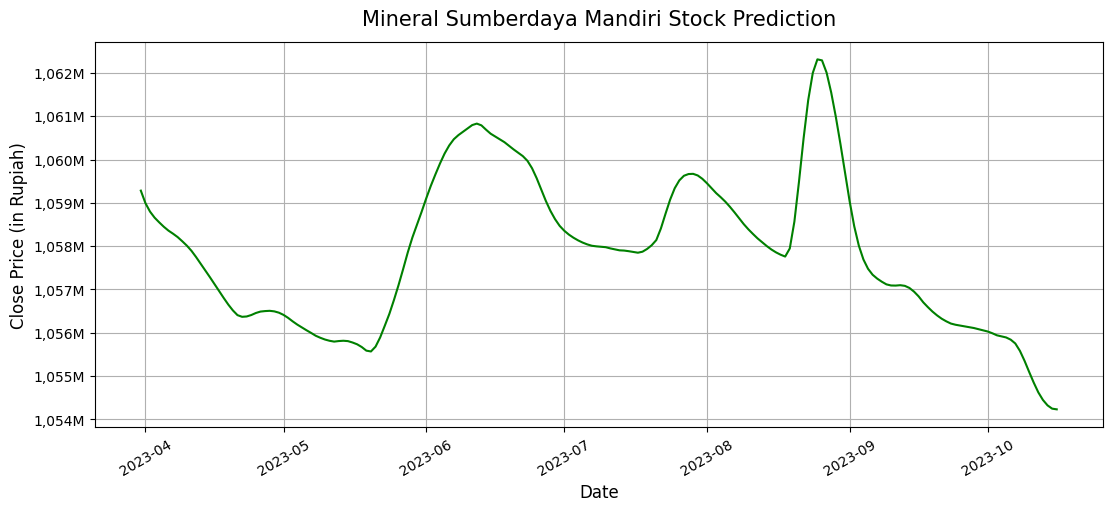

In [215]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [216]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 18s 465ms/step - loss: 0.0545 - val_loss: 0.0578
Epoch 2/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0160 - val_loss: 0.0398
Epoch 3/10
24/24 [==============================] - 10s 430ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 4/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0042 - val_loss: 0.0068
Epoch 5/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 6/10
24/24 [==============================] - 10s 405ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 7/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch 8/10
24/24 [==============================] - 10s 427ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 9/10
24/24 [==============================] - 10s 421ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 10/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0027 - val_lo

In [217]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.0133187
Mean Absolute Percentage Error (MAPE): 0.08828
Root Mean Squared Error (RMSE): 0.02301
Mean Squared Error (MSE): 0.0005293
R-Squared (R2): -0.294086
T-Statistic 0.6954
P-Value 1.6158698616410634e-20
Elapsed Time (min): 109.99


7/7 [==============================] - 0s 54ms/step


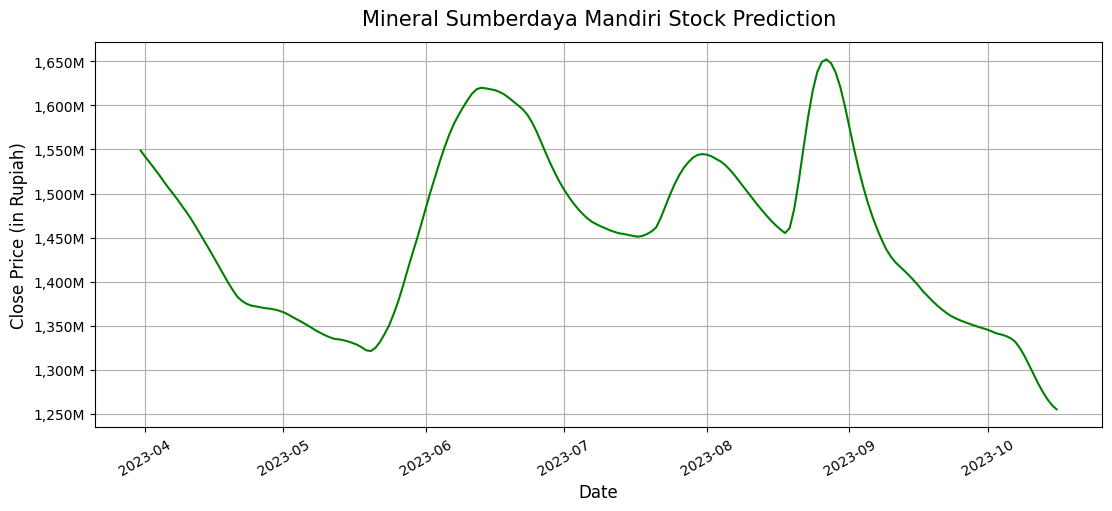

In [218]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [219]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 18s 474ms/step - loss: 0.0046 - val_loss: 0.0092
Epoch 2/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 3/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 10s 398ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 8/10
24/24 [==============================] - 10s 429ms/step - loss: 8.4337e-04 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 10s 418ms/step - loss: 7.7495e-04 - val_loss: 0.0023
Epoch 10/10
24/24 [==============================] - 10s 400ms/step - loss: 7.6840e

In [220]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 53ms/step
Mean Absolute Error (MAE): 0.0192328
Mean Absolute Percentage Error (MAPE): 0.12722
Root Mean Squared Error (RMSE): 0.0228
Mean Squared Error (MSE): 0.0005197
R-Squared (R2): -0.270645
T-Statistic 0.8702
P-Value 2.386199419480983e-13
Elapsed Time (min): 108.86


7/7 [==============================] - 0s 53ms/step


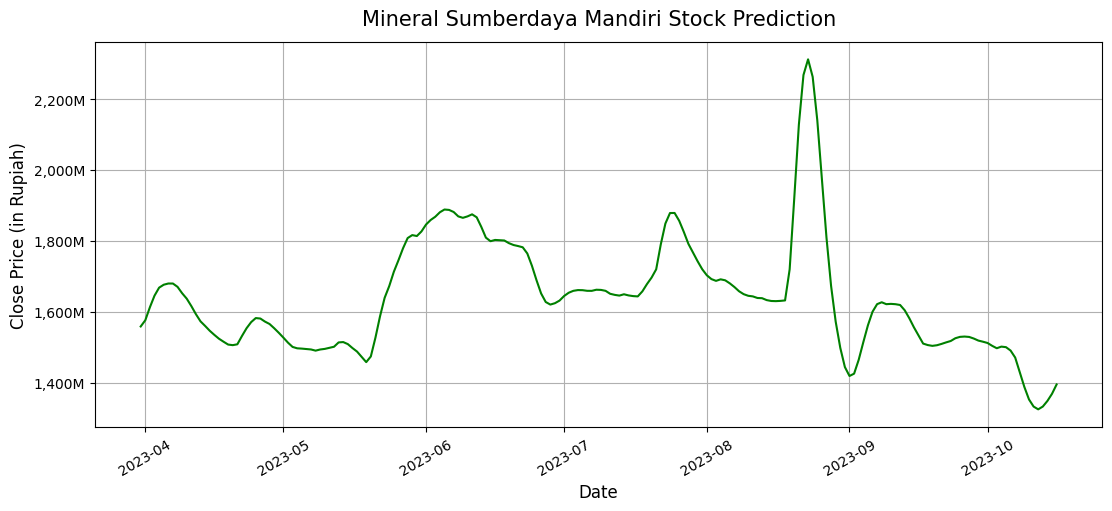

In [221]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [222]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 17s 466ms/step - loss: 0.0199 - val_loss: 0.0800
Epoch 2/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0155 - val_loss: 0.0671
Epoch 3/10
24/24 [==============================] - 10s 427ms/step - loss: 0.0147 - val_loss: 0.0624
Epoch 4/10
24/24 [==============================] - 10s 400ms/step - loss: 0.0143 - val_loss: 0.0600
Epoch 5/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0141 - val_loss: 0.0586
Epoch 6/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0137 - val_loss: 0.0565
Epoch 7/10
24/24 [==============================] - 11s 441ms/step - loss: 0.0133 - val_loss: 0.0554
Epoch 8/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0133 - val_loss: 0.0544
Epoch 9/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0128 - val_loss: 0.0530
Epoch 10/10
24/24 [==============================] - 10s 413ms/step - loss: 0.0125 - val_lo

In [223]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 66ms/step
Mean Absolute Error (MAE): 0.0443995
Mean Absolute Percentage Error (MAPE): 0.28459
Root Mean Squared Error (RMSE): 0.04841
Mean Squared Error (MSE): 0.0023436
R-Squared (R2): -4.73006
T-Statistic 0.7652
P-Value 3.7436912394200575e-18
Elapsed Time (min): 110.03


7/7 [==============================] - 0s 55ms/step


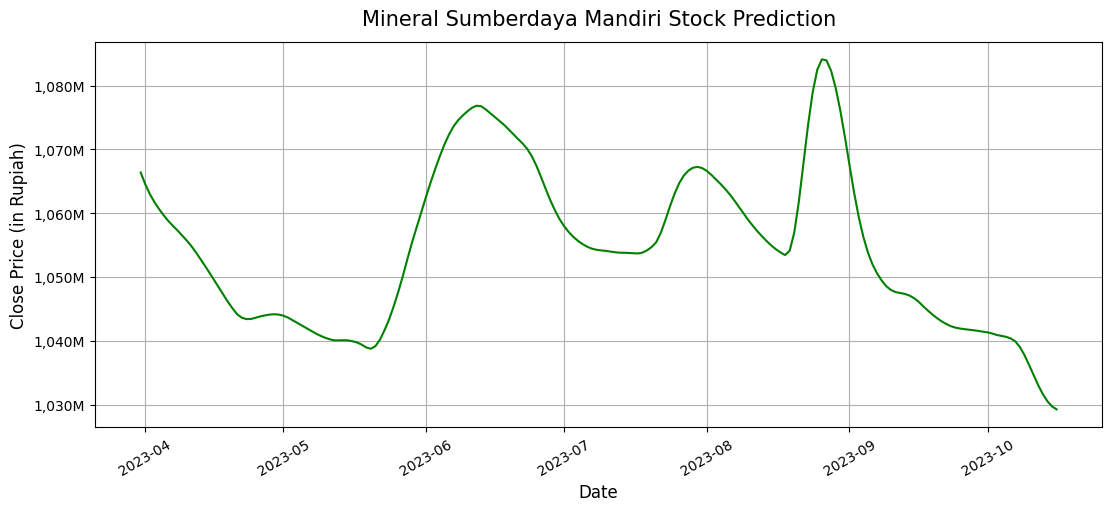

In [224]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [225]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 20s 492ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 2/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 3/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 5/10
24/24 [==============================] - 10s 422ms/step - loss: 9.3753e-04 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 10s 437ms/step - loss: 8.9481e-04 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 11s 444ms/step - loss: 8.3815e-04 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 11s 451ms/step - loss: 8.8954e-04 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 11s 454ms/step - loss: 7.1699e-04 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 11s 453ms/step - l

In [226]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.014555
Mean Absolute Percentage Error (MAPE): 0.09527
Root Mean Squared Error (RMSE): 0.01892
Mean Squared Error (MSE): 0.0003581
R-Squared (R2): 0.124507
T-Statistic 0.881
P-Value 1.0406757920689014e-12
Elapsed Time (min): 116.83


7/7 [==============================] - 0s 54ms/step


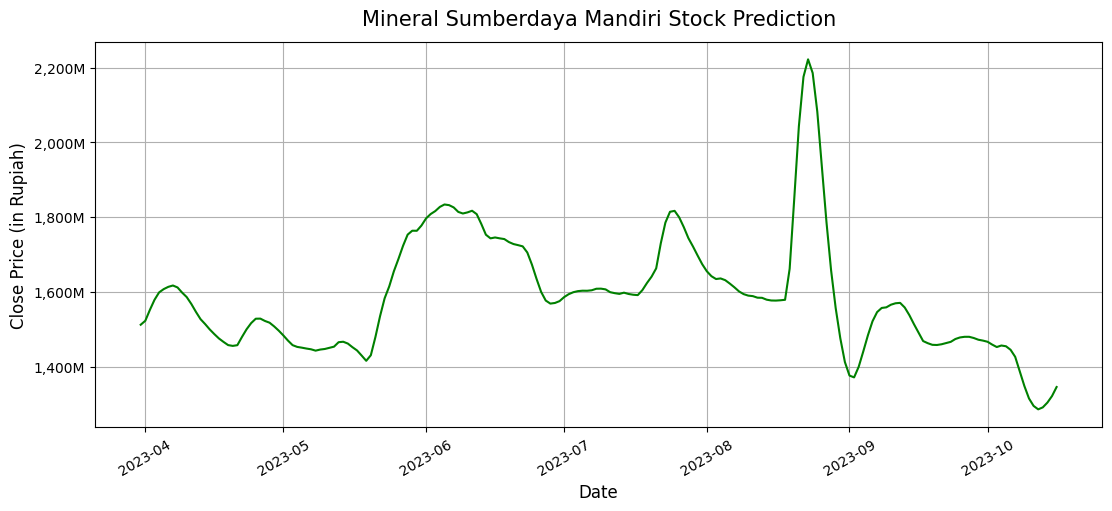

In [227]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [228]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 18s 484ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 2/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 3/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 5/10
24/24 [==============================] - 11s 474ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 7/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 8/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 11s 468ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0014 - val_lo

In [229]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 58ms/step
Mean Absolute Error (MAE): 0.0213475
Mean Absolute Percentage Error (MAPE): 0.14184
Root Mean Squared Error (RMSE): 0.02576
Mean Squared Error (MSE): 0.0006638
R-Squared (R2): -0.622879
T-Statistic 0.8721
P-Value 3.070655979920539e-13
Elapsed Time (min): 117.03


7/7 [==============================] - 0s 48ms/step


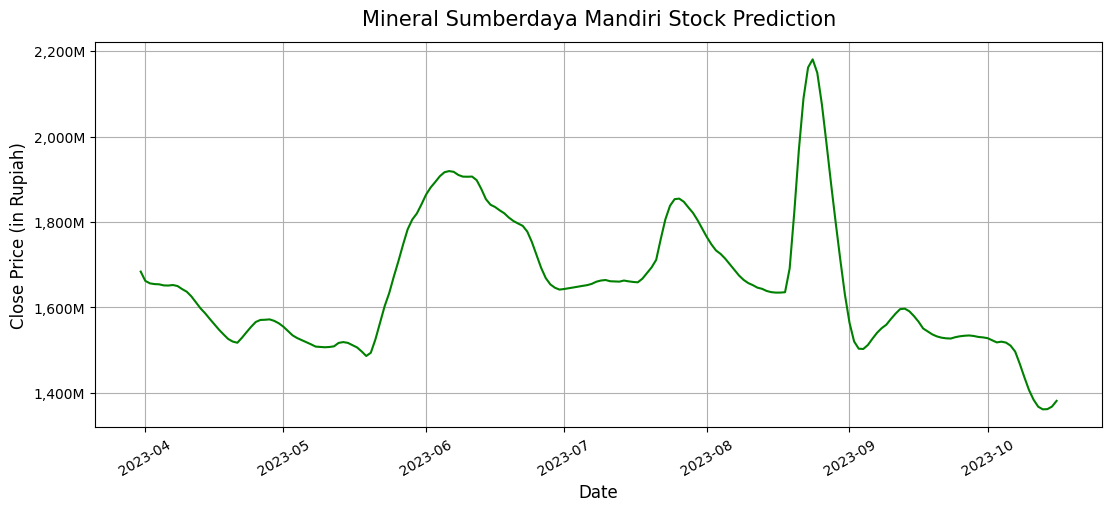

In [230]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [231]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 19s 477ms/step - loss: 0.0281 - val_loss: 0.1341
Epoch 2/10
24/24 [==============================] - 10s 430ms/step - loss: 0.0278 - val_loss: 0.1327
Epoch 3/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0274 - val_loss: 0.1312
Epoch 4/10
24/24 [==============================] - 10s 405ms/step - loss: 0.0269 - val_loss: 0.1298
Epoch 5/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0266 - val_loss: 0.1283
Epoch 6/10
24/24 [==============================] - 12s 497ms/step - loss: 0.0262 - val_loss: 0.1269
Epoch 7/10
24/24 [==============================] - 12s 507ms/step - loss: 0.0259 - val_loss: 0.1254
Epoch 8/10
24/24 [==============================] - 12s 481ms/step - loss: 0.0257 - val_loss: 0.1240
Epoch 9/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0252 - val_loss: 0.1225
Epoch 10/10
24/24 [==============================] - 11s 472ms/step - loss: 0.0250 - val_lo

In [232]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 55ms/step
Mean Absolute Error (MAE): 0.146567
Mean Absolute Percentage Error (MAPE): 0.97489
Root Mean Squared Error (RMSE): 0.14799
Mean Squared Error (MSE): 0.0219018
R-Squared (R2): -52.550061
T-Statistic 0.6484
P-Value 6.879404781120222e-22
Elapsed Time (min): 117.94


7/7 [==============================] - 0s 52ms/step


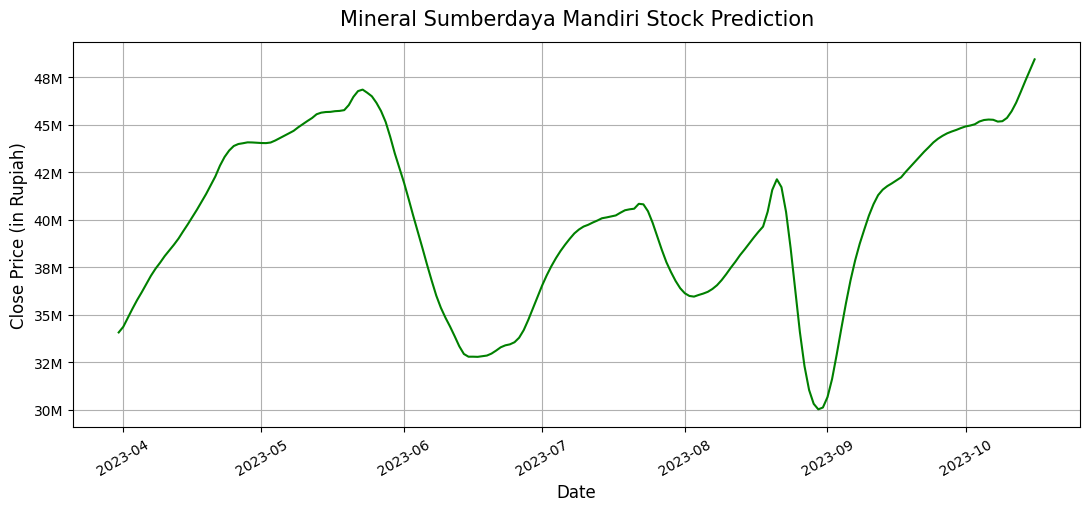

In [233]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [234]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 21s 561ms/step - loss: 0.0155 - val_loss: 0.0600
Epoch 2/10
24/24 [==============================] - 10s 428ms/step - loss: 0.0131 - val_loss: 0.0548
Epoch 3/10
24/24 [==============================] - 10s 424ms/step - loss: 0.0122 - val_loss: 0.0495
Epoch 4/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0118 - val_loss: 0.0473
Epoch 5/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0110 - val_loss: 0.0429
Epoch 6/10
24/24 [==============================] - 10s 430ms/step - loss: 0.0103 - val_loss: 0.0380
Epoch 7/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0097 - val_loss: 0.0385
Epoch 8/10
24/24 [==============================] - 10s 430ms/step - loss: 0.0091 - val_loss: 0.0355
Epoch 9/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0086 - val_loss: 0.0334
Epoch 10/10
24/24 [==============================] - 10s 430ms/step - loss: 0.0082 - val_lo

In [235]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 53ms/step
Mean Absolute Error (MAE): 0.0366961
Mean Absolute Percentage Error (MAPE): 0.23549
Root Mean Squared Error (RMSE): 0.04037
Mean Squared Error (MSE): 0.0016294
R-Squared (R2): -2.983821
T-Statistic 0.6852
P-Value 7.917610456850625e-21
Elapsed Time (min): 115.3


7/7 [==============================] - 0s 51ms/step


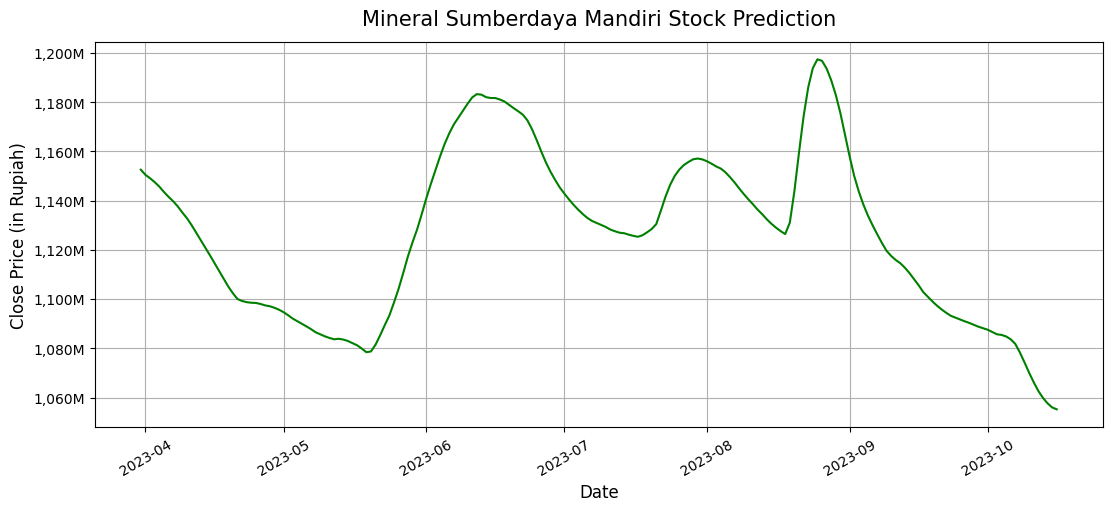

In [236]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [237]:
# define the model
import time
start_time=time.time()
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/aksi_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 20s 500ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 2/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 3/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 4/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 7/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 9/10
24/24 [==============================] - 11s 441ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 11s 464ms/step - loss: 9.6976e-04 - va

In [238]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform shapiro-wilk test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 52ms/step
Mean Absolute Error (MAE): 0.009806
Mean Absolute Percentage Error (MAPE): 0.06264
Root Mean Squared Error (RMSE): 0.01722
Mean Squared Error (MSE): 0.0002964
R-Squared (R2): 0.275403
T-Statistic 0.8762
P-Value 5.361500631483052e-13
Elapsed Time (min): 117.74


7/7 [==============================] - 0s 52ms/step


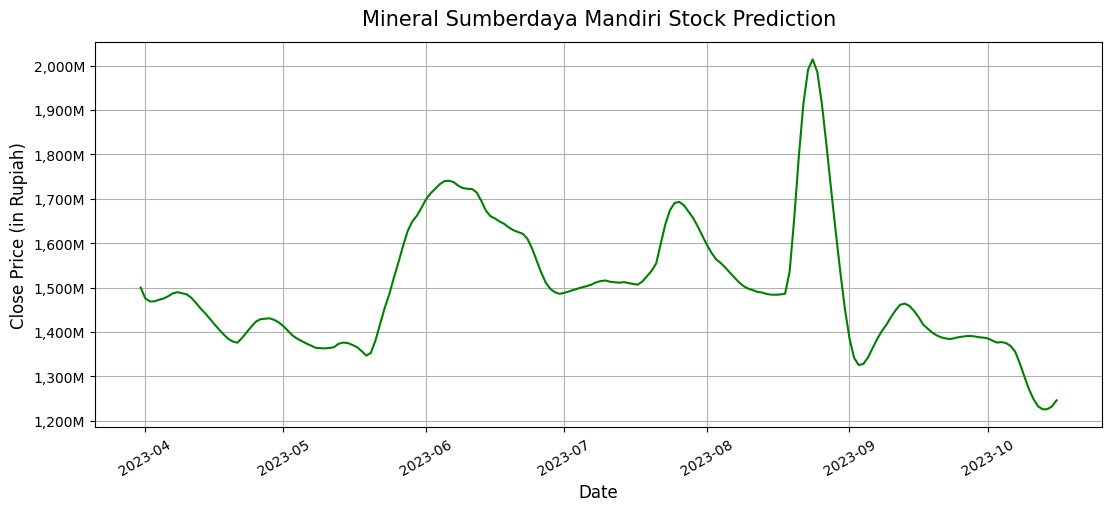

In [239]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_aksi.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='green')
plt.title('Mineral Sumberdaya Mandiri Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [240]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
import time
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 57ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 57ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 50ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 54ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 44ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 45ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 45ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 51ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 50ms/step
Training

In [241]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta               107.15  0.13989   0.92974  0.01998   
           adagrad                109.11  0.04040   0.25858  0.00197   
           adam                   101.81  0.00833   0.05237  0.00019   
           adamax                  86.68  0.01011   0.06455  0.00031   
           nadam                  114.02  0.00753   0.04747  0.00018   
           rmsprop                117.08  0.01279   0.08424  0.00033   
           sgd                    105.54  0.02938   0.18882  0.00110   
relu       adadelta                86.39  0.14051   0.93393  0.02015   
           adagrad                 86.25  0.04967   0.32023  0.00284   
           adam                    82.52  0.01054   0.06853  0.00024   
           adamax                  74.39  0.02522   0.17043  0.00086   
           nadam                   91.57  0.01353   0.08745  0.00031   
           rmsprop                 88.64  0.02167   0.14143  0.00065   
           sgd                     80.21  0.03644   0.23313  0.00162   
sigmoid    adadelta                77.71  0.11206   0.77445  0.01295   
           adagrad                 77.66  0.05522   0.35706  0.00346   
           adam                    75.38  0.01633   0.10831  0.00052   
           adamax                  82.25  0.01244   0.08150  0.00041   
           nadam                   81.28  0.02606   0.17868  0.00094   
           rmsprop                 80.48  0.03147   0.20575  0.00126   
           sgd                     77.23  0.05604   0.36253  0.00355   
tanh       adadelta                80.58  0.13959   0.92815  0.01988   
           adagrad                 79.21  0.04480   0.28689  0.00239   
           adam                    76.89  0.00791   0.05022  0.00018   
           adamax                  71.09  0.00977   0.06243  0.00030   
           nadam                   82.24  0.01150   0.07365  0.00026   
           rmsprop                 81.37  0.01808   0.12028  0.00051   
           sgd                     73.14  0.03396   0.21700  0.00144   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   1.680251e-20         -47.86   0.14135     0.695927  
           adagrad    3.992393e-21          -3.81   0.04438     0.675196  
           adam       2.394789e-12           0.54   0.01378     0.886884  
           adamax     6.918922e-13           0.24   0.01761     0.878079  
           nadam      2.341222e-12           0.56   0.01342     0.886728  
           rmsprop    3.957653e-13           0.20   0.01817     0.873969  
           sgd        4.853629e-21          -1.68   0.03317     0.678075  
relu       adadelta   5.592775e-21         -48.28   0.14195     0.680152  
           adagrad    1.089623e-19          -5.94   0.05329     0.721383  
           adam       3.493118e-12           0.42   0.01549     0.889473  
           adamax     3.837460e-14          -1.11   0.02933     0.855763  
           nadam      8.907515e-13           0.24   0.01761     0.879907  
           rmsprop    3.434370e-12          -0.59   0.02550     0.889358  
           sgd        5.786784e-20          -2.97   0.04025     0.712952  
sigmoid    adadelta   1.123102e-19         -30.67   0.11380     0.721781  
           adagrad    4.376211e-21          -7.46   0.05882     0.676551  
           adam       2.112493e-13          -0.26   0.02280     0.869237  
           adamax     7.616839e-14           0.00   0.02025     0.861289  
           nadam      1.147377e-16          -1.29   0.03066     0.802468  
           rmsprop    6.500454e-15          -2.09   0.03550     0.840735  
           sgd        1.422784e-10          -7.69   0.05958     0.912829  
tanh       adadelta   6.796298e-14         -47.61   0.14100     0.860381  
           adagrad    3.352104e-22          -4.85   0.04889  

In [242]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

,,Elapsed Time (min),MAE (%),MAPE (%),MSE (%),P-Value,R-Squared (%),RMSE (%),T-Statistic
Activation,Optimizer,,,,,,,,
linear,nadam,114.02,0.00753,0.04747,0.00018,2.341222e-12,0.56,0.01342,0.886728
tanh,adam,76.89,0.00791,0.05022,0.00018,1.196313e-12,0.55,0.01342,0.882017
linear,adam,101.81,0.00833,0.05237,0.00019,2.394789e-12,0.54,0.01378,0.886884
tanh,adamax,71.09,0.00977,0.06243,0.00030,3.507819e-13,0.26,0.01732,0.873069
linear,adamax,86.68,0.01011,0.06455,0.00031,6.918922e-13,0.24,0.01761,0.878079
relu,adam,82.52,0.01054,0.06853,0.00024,3.493118e-12,0.42,0.01549,0.889473
tanh,nadam,82.24,0.01150,0.07365,0.00026,1.408637e-12,0.36,0.01612,0.883176
sigmoid,adamax,82.25,0.01244,0.08150,0.00041,7.616839e-14,0.00,0.02025,0.861289
linear,rmsprop,117.08,0.01279,0.08424,0.00033,3.957653e-13,0.20,0.01817,0.873969


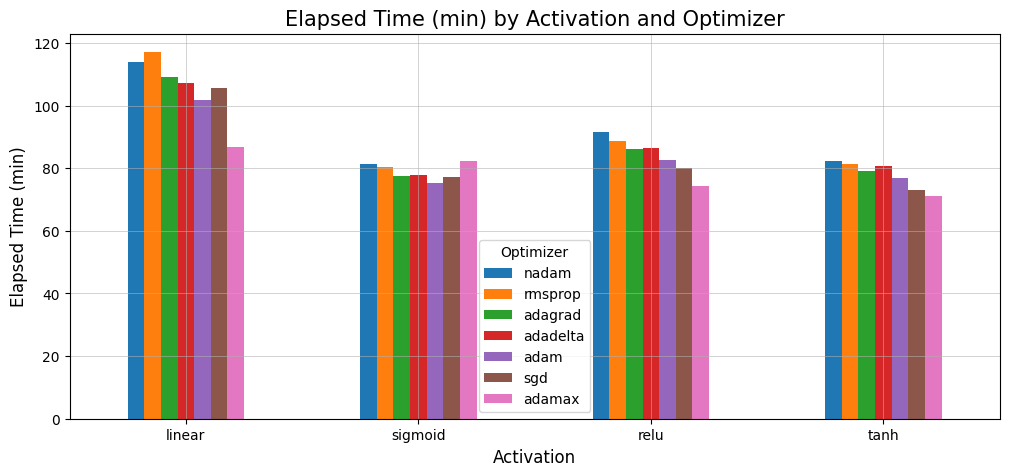

In [243]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

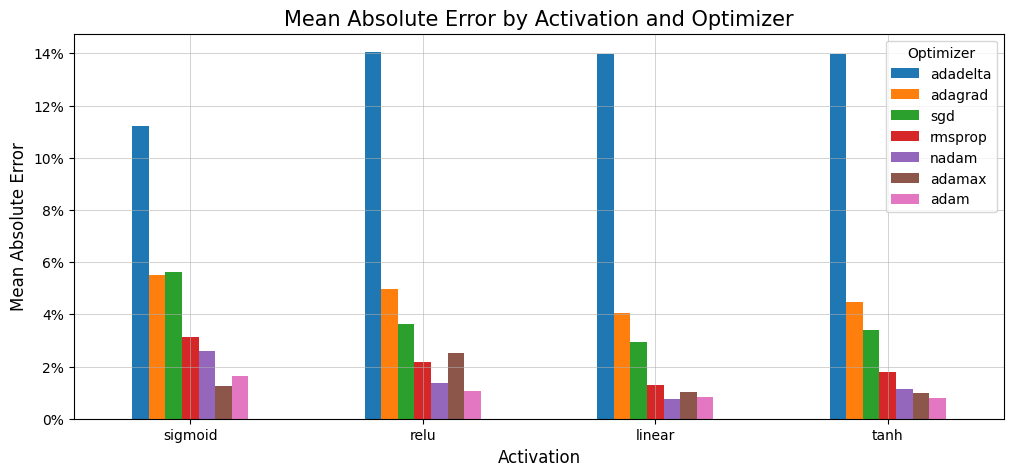

In [244]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

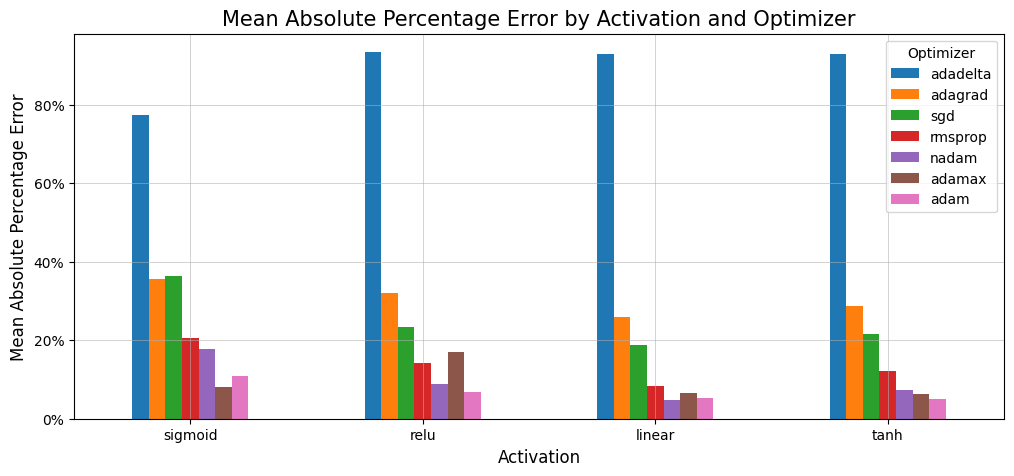

In [245]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

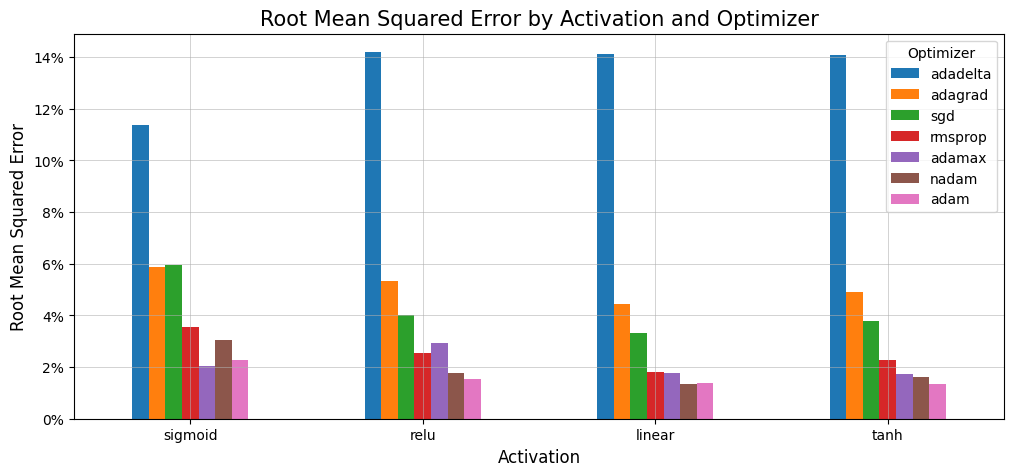

In [246]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

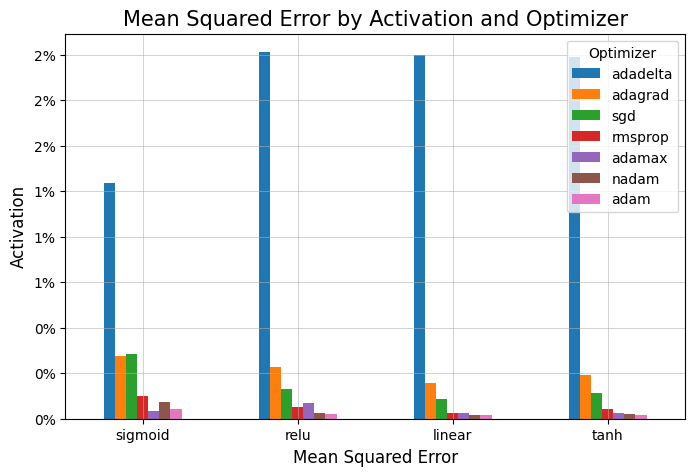

In [247]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Mean Squared Error', fontsize=12)
ax.set_ylabel('Activation', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

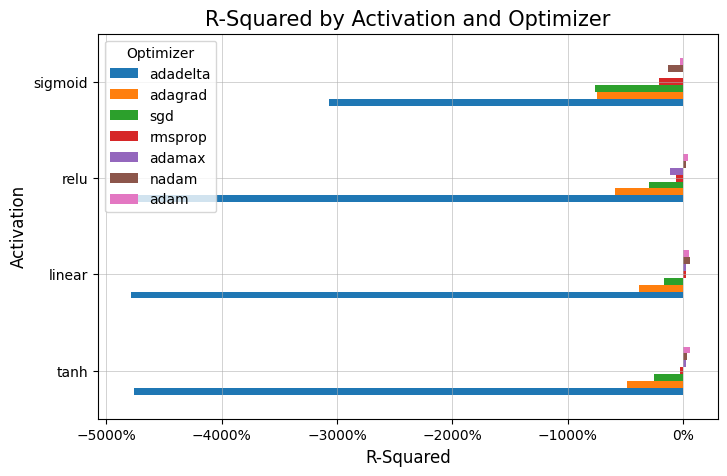

In [248]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()